In [8]:
import nest
import h5py
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')

from neuron_response_analysis import (
    SingleNeuronModel, 
    plot_single_response, 
)

from neuron_response_analysis import analyze_current_response as analyze_current_response_chen

In [2]:
def chen_to_bmtk_mapping_dict(chen_network_path='Allen_V1_param/network_dat.pkl', 
                              bmtk_nodes_path='Allen_V1_param/network/v1_nodes.h5'):
    
    """ 给出chen 111个神经元模板和bmtk 111给神经元模板之间的对应关系 """

    chen_to_bmtk_mapping = {}

    with h5py.File(bmtk_nodes_path, 'r') as f:
        node_type_ids = f['nodes']['v1']['node_type_id'][:]
    with open(chen_network_path, 'rb') as f:
        chen_data = pkl.load(f)

    for chen_neuron_model_template_index in range(111):
        unique_set = list(set(node_type_ids[chen_data['nodes'][chen_neuron_model_template_index]['ids']]))
        # 验证集合元素数量
        if len(unique_set) == 0:
            raise ValueError("未找到bmtk神经元模板")
        elif len(unique_set) == 1:
            chen_to_bmtk_mapping[chen_neuron_model_template_index] = unique_set[0]
        else:
            raise ValueError(f"出现多个bmtk神经元模板与之对应")
            
    return chen_to_bmtk_mapping

In [3]:
def simulate_neuron_response(node_type_id, platform_current,
                             T=1000, dt=0.1, current_start=200, current_end=800):
    node_types = pd.read_csv('Allen_V1_param/network/v1_node_types.csv')
    h5_nodes = h5py.File('Allen_V1_param/network/v1_nodes.h5', 'r')
    model_template = 'glif_psc'
    dynamics_path = f'Allen_V1_param/components/cell_models/nest_models/'+str(node_type_id)+'_glif_psc.json'
    with open(dynamics_path, 'r') as f:
        dynamics_params = json.load(f)
        
    # 创建NEST模型
    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': dt})  # 0.1 ms 时间分辨率

    # 注册模型
    neuron = nest.Create(model_template, 1, params=dynamics_params)
    
    # Step 3: 添加multimeter记录膜电位
    mm = nest.Create("multimeter", params={
        "interval": dt,
        "record_from": ["V_m"]
    })
    nest.Connect(mm, neuron)
    
    # Step 4: 注入平台电流
    stim = nest.Create("dc_generator", params={
        "amplitude": platform_current,  # 单位: pA
        "start": current_start,      # ms
        "stop": current_end       # ms
    })
    nest.Connect(stim, neuron)

    # Step 5: 仿真并记录
    nest.Simulate(T)
    data = nest.GetStatus(mm)[0]["events"]
    time = data["times"]
    voltages = data["V_m"]
    
    spikes = np.zeros(voltages.shape)
    spikes[np.where(np.gradient(voltages)<-5)[0][0::2]-1] = 1
    
    # 根据实际记录的时间点创建对应的电流序列
    current_sequence = np.zeros(len(time), dtype=np.float32)
    current_mask = (time >= current_start) & (time <= current_end)
    current_sequence[current_mask] = platform_current
    
    return time, current_sequence, voltages, spikes

In [35]:
def analyze_current_response_nest(node_type_id, current_amplitudes,
                             T=1000, dt=0.1, current_start=200, current_end=800):
    """
    分析神经元在不同电流强度下的响应
    
    参数:
    - neuron_type: 神经元类型
    - current_amplitudes: 电流强度列表
    - model_path: 模型文件路径
    - show_plot: 是否显示图像
    """
    
    # 创建多子图
    n_currents = len(current_amplitudes)
    fig, axes = plt.subplots(n_currents + 1, 1, figsize=(10, 2 * (n_currents + 1)), 
                            gridspec_kw={'hspace': 0.3})
    
    # 颜色映射
    colors = plt.cm.viridis(np.linspace(0, 1, n_currents))
    
    # 第一个子图：显示所有电流波形
    time_ref = np.arange(T)  # 参考时间序列
    for i, current_amp in enumerate(current_amplitudes):
        current_waveform = np.zeros(T)
        current_waveform[current_start:current_end] = current_amp
        axes[0].plot(time_ref, current_waveform, color=colors[i], linewidth=2, 
                    label=f'{current_amp} pA')
    
    axes[0].set_ylabel('Current (pA)', fontsize=12)
    axes[0].set_title(f'{node_type_id} neuron response', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 存储结果用于分析
    all_results = []
    
    # 对每个电流强度进行仿真
    for i, current_amp in enumerate(current_amplitudes):
        print(f"\n处理电流强度: {current_amp} pA ({i+1}/{n_currents})")
        
        # 运行仿真
        time, current, voltage, spikes = simulate_neuron_response(node_type_id, current_amp,
                                                                  T=T, dt=dt, current_start=current_start, current_end=current_end)
        
        # 存储结果
        spike_count = np.sum(spikes > 0.5)
        firing_rate = spike_count / ( (current_end - current_start) / 1000)
        all_results.append({
            'current': current_amp,
            'spike_count': spike_count,
            'firing_rate': firing_rate,
            'voltage': voltage,
            'spikes': spikes
        })
        
        # 绘制到对应子图
        ax = axes[i + 1]
        ax.plot(time, voltage, color='black', linewidth=1.5, label='V_m')
        
        # 添加脉冲标记（在对应时间点的膜电位上画红色竖线）
        spike_indices = np.where(spikes > 0.5)[0]
        for spike_idx in spike_indices:
            spike_voltage = voltage[spike_idx]  # 获取脉冲时刻的膜电位值
            ax.plot(time[spike_idx], spike_voltage, '|k', markersize=10, color='red')
        
        ax.set_ylabel('V_m (mV)', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.text(0.02, 0.98, f'{current_amp} nA\n spike: {spike_count}\n rate: {firing_rate:.1f} Hz', 
                transform=ax.transAxes, verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    axes[-1].set_xlabel('时间 (ms)', fontsize=12)
    plt.tight_layout(pad=0.5)
    
    return all_results

def plot_if_curve(neuron_type, results_chen, results_nest, save_dir=None):
    """
    绘制电流-发放频率(I-F)曲线
    
    参数:
    - neuron_type: 神经元类型
    - results: 仿真结果列表
    """
    
    plt.figure(figsize=(6,3))
    
    currents = [r['current'] for r in results_chen]
    firing_rates = [r['firing_rate'] for r in results_chen]
    plt.plot(currents, firing_rates, 'bo-', linewidth=2, markersize=8, color='red', label='Chen')  
    plt.xlabel('input current (nA)', fontsize=12)
    plt.ylabel('firing rate (Hz)', fontsize=12)
    plt.title(f'{neuron_type} I-F curve', fontsize=14)
    
    currents = [r['current'] for r in results_nest]
    firing_rates = [r['firing_rate'] for r in results_nest]
    plt.plot(currents, firing_rates, 'v-', linewidth=2, markersize=8, color='blue', label='NEST')
    
    plt.legend()
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(save_dir + '/' + f'{neuron_type}_if_curve.png', dpi=100)

In [5]:
chen_to_bmtk_mapping = chen_to_bmtk_mapping_dict()


Jul 11 21:35:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 11 21:35:19 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 11 21:35:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 11 21:35:19 SimulationManager::run [Info]: 
    Simulation finished.


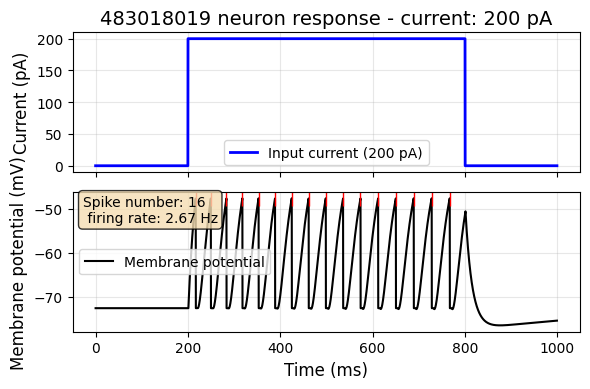

In [22]:
chen_neuron_model_template_index = 50
node_type_id = chen_to_bmtk_mapping[chen_neuron_model_template_index]
platform_current = 200
time, current, voltage, spikes = simulate_neuron_response(node_type_id=node_type_id, 
                                                          platform_current=platform_current)

fig = plot_single_response(
    time, current, voltage, spikes, 
    node_type_id, platform_current
)


处理电流强度: 0 pA (1/18)

Jul 11 21:36:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 11 21:36:16 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 11 21:36:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 11 21:36:16 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 15 pA (2/18)

Jul 11 21:36:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 11 21:36:16 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jul 11 21:36:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jul 11 21:36:16 SimulationManager::run [Info]: 
    Simulation finished.

处理电流强度: 30 pA (3/18)

Jul 11 21:36:16 SimulationManager::set_status 

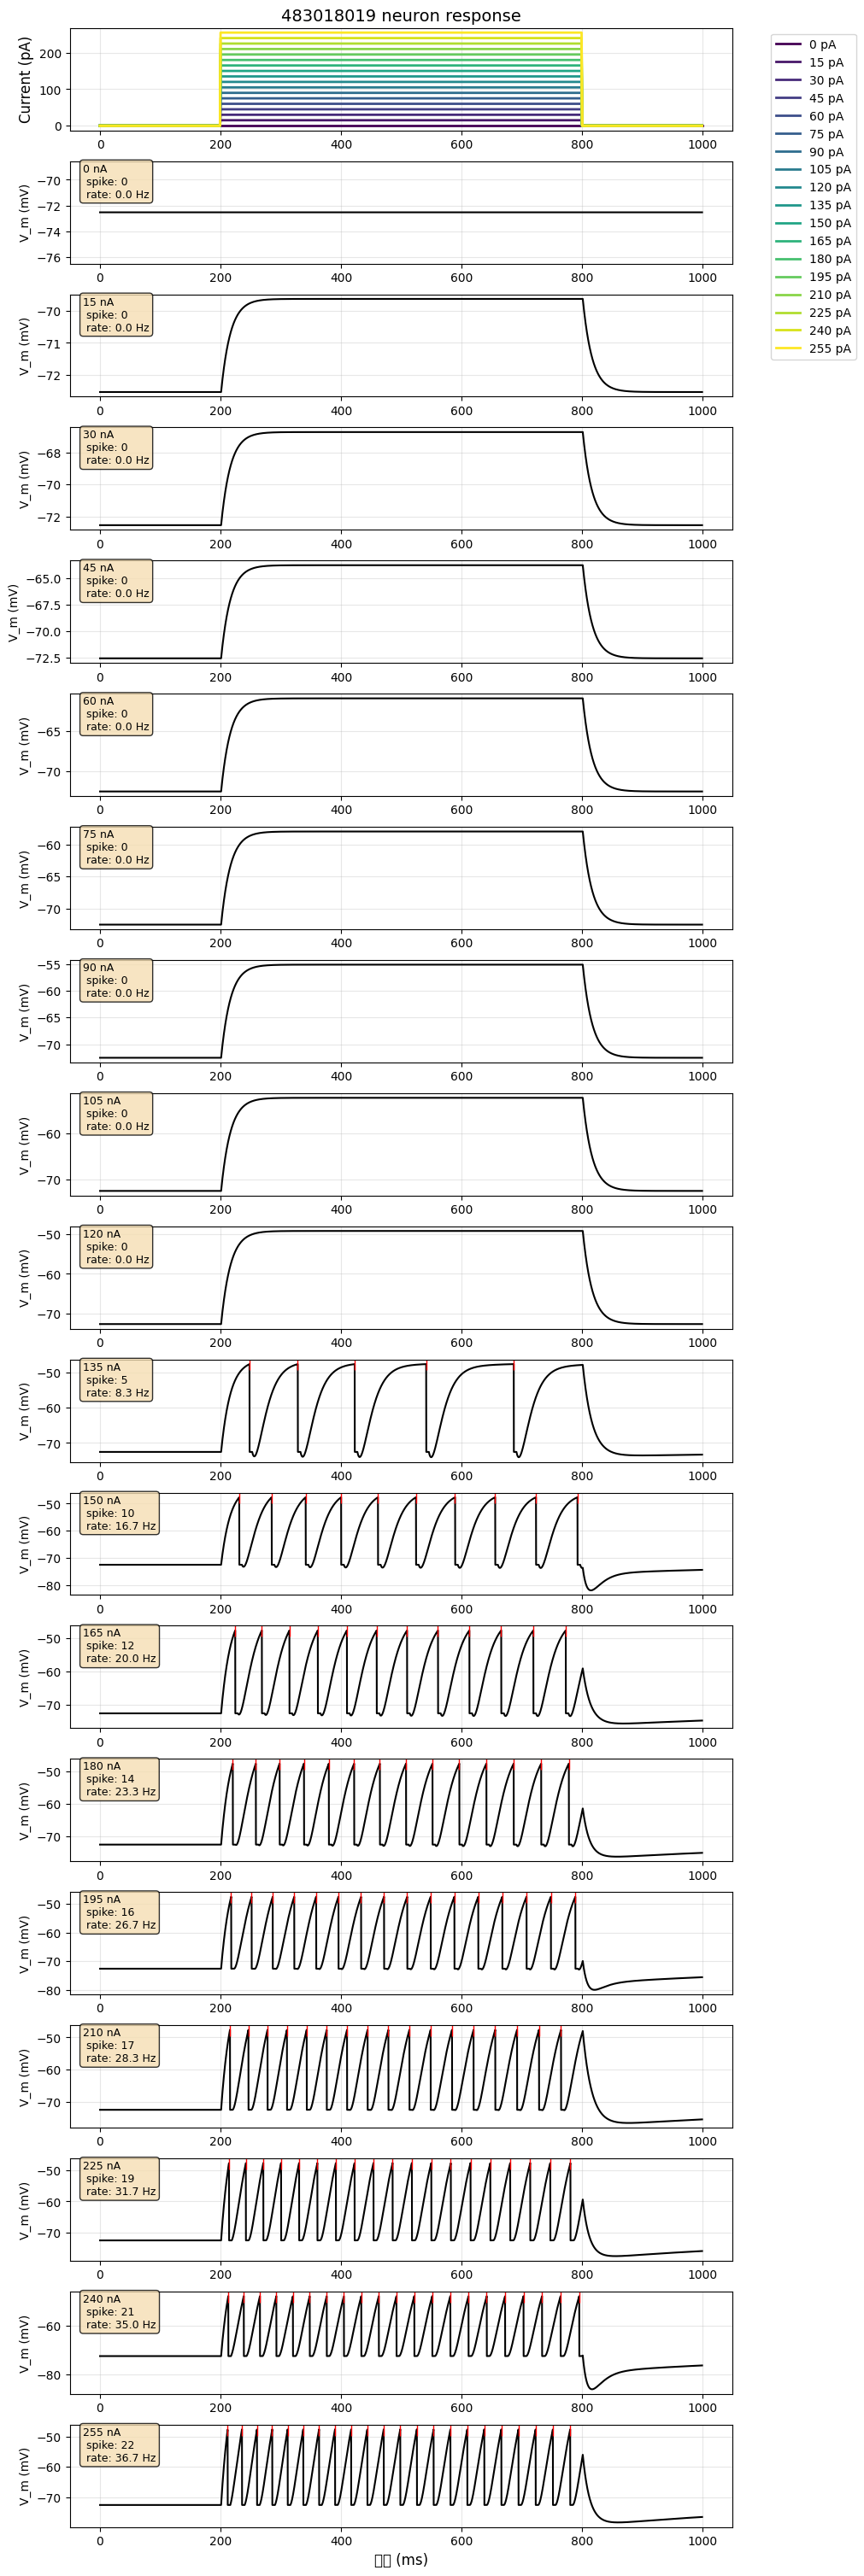

In [24]:
chen_neuron_model_template_index = 50
node_type_id = chen_to_bmtk_mapping[chen_neuron_model_template_index]
current_amplitudes = np.arange(0,270,15)
T = 1000
current_start = 200
current_end = 800

# 运行分析
results = analyze_current_response(
    node_type_id=node_type_id,
    current_amplitudes=current_amplitudes,
    T=T, current_start=current_start, current_end=current_end
)

In [ ]:
T = 1000  # ms
current_start = 200
current_end = 800
platform_current = np.arange(0,750,15)
    
for neuron_model_template_index in range(111):
    # Chen neuron test
    neuron = SingleNeuronModel(neuron_model_template_index, model_path='../GLIF_network/network_dat.pkl')
    results_chen = analyze_current_response_chen(
        neuron_model_template_index,
        neuron, T, platform_current, current_start, current_end
    )
    # NEST neuron test
    node_type_id = chen_to_bmtk_mapping[neuron_model_template_index]
    results_nest = analyze_current_response_nest(
        node_type_id=node_type_id,
        current_amplitudes=platform_current,
        T=T, current_start=current_start, current_end=current_end
    )
    # plot I-F curve and save
    plot_if_curve(neuron_model_template_index, results_chen, results_nest, save_dir='single_neuron_compare')